**Author** : V.Joan Aléonard<br>
**Last update** :  30 March 2021

# <font color=red><center>**AVIS RESTAU**</center></font>

**Avis Restau** is a website which connects clients and restaurants:
- The clients can publish reviews and photos of the restaurants;
- The restaurants can leverage from customer's feedbacks for improvement.

**As Data scientist for Avis Restau**, our mission is summarized as follows:

| **Task** | **Objective** | **Available notebook** |
| :-- | :-- | :-- |
| Analyze customers' reviews | **Detect customer's insatisfaction topics** | Notebook N°1 |
| Treat photo posted by customers | **Classify automatically customer's photos** | **<font color=green>Notebook N°2</font>** |
| Collect new data throuhg API | **Enrich our database** | Notebook N°3 |

This notebook is dedicated to 2nd task : classify automatically customer's photos by categories.

# <font color=brown><center>**NOTEBOOK 2<br>CUSTOMER PICTURE CLASSIFICATION<br>USING KERAS with TENSORFLOW BACKEND**</center></font>

**Avis Restau** needs to be able to **classify automatically the pictures** published by their users about one restaurant, in **5 categories (or labels): food, drink, menu, inside, outside**.

So far, Avis Restau doesn't have enough images to train properly an *image classification model*.

Therefore, we will use **Yelp Dataset** to train our model, because at our disposal, we will have:
- a JSON file with **200k images** tracked by their **true labels**;
- a folder which contains the 200k images.

However, we will use only a subset of this database (10%, ~20k images).

Besides, in this notebook, we will use **Keras API** (*Application Programming Interface*) - which is fully integrated **with Tensorflow backend**, to build and evaluate our Deep Learning model(s).

# <font color=salmon>PART 1 - IMAGES STORAGE ORGANIZATION</font>

As first **vital step** before **building an accurate image classifier**, we need to construct a **reliable training sets of photos with pre-assigned class labels** (food, drink, menu, inside, outside).

Therefore, we will **organize our images into folders** in such a way that we can use them easily with **Keras API** (*Application Programming Interface*), to build and evaluate our **image classification model**.

In this part, we will:
- load the JSON file and create a sample DataFrame;
- separate the sample DataFrame into train/validation/test sets;
- create manually all folders (train, validation and test) and subfolders (one per category);
- programmatically, move images to the correct subfolders based on image IDs in each set.

In [ ]:
# -*- coding: uft-8 -*-
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from pathlib import Path

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
# Define all main folders
src_folder = Path('C:/Users/LaFamille/Documents/_Ingénieur_IA/Projet_6')
img_folder = Path(src_folder / 'photos_dir')
train_folder = Path(src_folder / 'train_dir')
test_folder = Path(src_folder / 'test_dir')
valid_folder = Path(src_folder / 'valid_dir')
model_folder = Path(src_folder / 'models_dir')

## <font color=green>P1.1 - Load dataframe and check photos distribution</font>

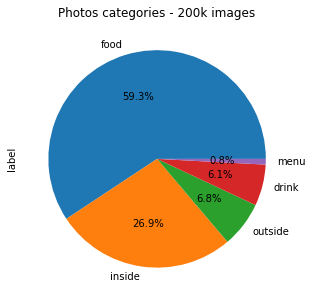

In [ ]:
# Read JSON file
photos_df = pd.read_json((src_folder / 'photos.json'),
                         lines=True)

# Plot pie to check distribution
plt.figure(figsize=(8,5))

photos_df.label.value_counts().plot(kind='pie',
                                    autopct='%1.1f%%')
plt.title('Photos categories - 200k images')
plt.show()

Here, we can see that we have 5 classes, but it has far away more data on food than in menu. 

Thus we can have **2 sampling strategies**:
1. We sample the images to have the same number of true labels;
2. We sample the images to keep the same distribution of true labels.

In this notebook, we choose the **2nd strategie**.

## <font color=green>P1.2 - Create sample DataFrame (10% ~20k images)</font>

We will use this **fixed snapshot to train and evaluatie our model(s)**.

***Hypothesis***: The sample is created in such a way that we keep the statistical distribution of the categories, as we assume it doesn't change over the time (stationary).

In [ ]:
# Create new column
photos_df['filename'] = photos_df['photo_id'].astype(str) + '.jpg'

# Create a reduced DF with selected columns
photos_df = photos_df[['filename', 'label']]

# Create a sample of the dataframe
sample_df = photos_df.groupby('label').apply(lambda x: x.sample(frac=0.1,
                                                                random_state=42))
sample_df.reset_index(drop=True, inplace=True)

# Display shape and 5 first rows
print(sample_df.shape)
sample_df.head()

(20001, 2)


,filename,label
0,7O_6jWQV83pxA2PrKFMKIQ.jpg,drink
1,psIz8-WCwUgL0Sjy9jRetQ.jpg,drink
2,4H1o4E0rIFjQhy1GG4JiAA.jpg,drink
3,njgpcVykSOSaS-Cz2sgpHg.jpg,drink
4,ps6qP0HCHB0a1fuHxIhn_A.jpg,drink


## <font color=green>P1.3 - Create Train, Validation and Test sets</font>

Here, we split the sample of 20k images into:
- **2k** each for validation and test sets;
- and the remaining **16k** for training set.

In [ ]:
from sklearn.model_selection import train_test_split

# Create first validation set with the whole dataset
train, valid_df = train_test_split(sample_df,
                                   test_size=2000,
                                   random_state=42,
                                   stratify=sample_df['label'])

# Create test and training set with the remaining dataset
train_df, test_df = train_test_split(train,
                                     test_size=2000,
                                     random_state=42,
                                     stratify=train['label'])

# Display shape
print('Train: ', train_df.shape)
print('Test: ', test_df.shape)
print('Validation: ', valid_df.shape)

Train:  (16001, 2)
Test:  (2000, 2)
Validation:  (2000, 2)


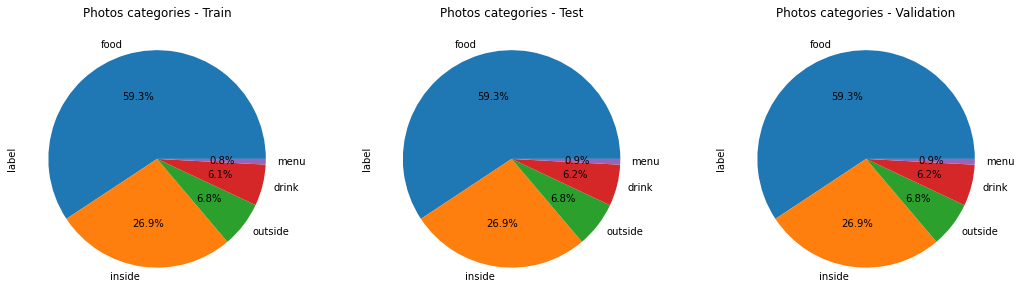

In [ ]:
# Plot the LABEL distribution of the 3 datasets
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

train_df.label.value_counts().plot(kind='pie',
                                   autopct='%1.1f%%',
                                   title='Photos categories - Train',
                                   ax=ax1)

test_df.label.value_counts().plot(kind='pie',
                                  autopct='%1.1f%%',
                                  title='Photos categories - Test',
                                  ax=ax2)

valid_df.label.value_counts().plot(kind='pie',
                                   autopct='%1.1f%%',
                                   title='Photos categories - Validation',
                                   ax=ax3)

plt.show()

In [ ]:
# Reset and set index based on column
train_df = train_df.sort_values(by=['filename'], ignore_index=True)
test_df = test_df.sort_values(by=['filename'], ignore_index=True)
valid_df = valid_df.sort_values(by=['filename'], ignore_index=True)

# Save to CSV file
# train_df.to_csv((src_folder / 'train_df.csv'), index=False)
# test_df.to_csv((src_folder / 'test_df.csv'), index=False)
# valid_df.to_csv((src_folder / 'valid_df.csv'), index=False)

# Read CSV file
train_df = pd.read_csv(src_folder / 'train_df.csv')
test_df = pd.read_csv(src_folder / 'test_df.csv')
valid_df = pd.read_csv(src_folder / 'valid_df.csv')

## <font color=green>P1.4 - Move images to destination folders</font>

Now that we have created our data into **train, validation and test sets**, we have to organize the images, and move them into classes sub-directories (for each separate data set).

<font color=red>*We will NOT run this part of the code again because all the images have been already moved.*</font>

In [ ]:
# Create a list of the classes
# ['drink', 'food', 'inside', 'menu', 'outside']
class_names = list(sample_df.label.unique())

# VALIDATION
# Loop over the image filenames by class labels
# for c in class_names:
    # by class labels, loop through image name
    # for img in list(valid_df[valid_df.label == c]['filename']):
        # Get the path to image at source directory
        # get_img = img_folder / img
        # Move the image to destination directory
        # move_img_to_categ = shutil.move(str(get_img), str(valid_folder / c))

# TEST
# Loop over the image filenames by class labels
# for c in class_names:
    # by class labels, loop through image name
    # for img in list(test_df[test_df.label == c]['filename']):
        # Get the path to image at source directory
        # get_img = img_folder / img
        # Move the image to destination directory
        # move_img_to_categ = shutil.move(str(get_img), str(test_folder / c))

# TRAIN
# Loop over the image filenames by class labels
# for c in class_names:
    # by class labels, loop through image name
    # for img in list(train_df[train_df.label == c]['filename']):
        # Get the path to image at source directory
        # get_img = img_folder / img
        # Move the image to destination directory
        # move_img_to_categ = shutil.move(str(get_img), str(train_folder / c))

In [ ]:
# Check the number of item in a folder
image_count = len(list(valid_folder.glob('*/*.jpg')))
print('VALIDATION Folder: ', image_count)
print('-----------------------------------------------')
print('Drink: ', len(os.listdir(valid_folder / 'drink')))
print('Food: ', len(os.listdir(valid_folder / 'food')))
print('Inside: ', len(os.listdir(valid_folder / 'inside')))
print('Menu: ', len(os.listdir(valid_folder / 'menu')))
print('Outside: ', len(os.listdir(valid_folder / 'outside')))

VALIDATION Folder:  2000
-----------------------------------------------
Drink:  123
Food:  1186
Inside:  538
Menu:  17
Outside:  136


In [ ]:
# Check the number of item in a folder
image_count = len(list(test_folder.glob('*/*.jpg')))
print('TEST Folder: ', image_count)
print('-----------------------------------------------')
print('Drink: ', len(os.listdir(test_folder / 'drink')))
print('Food: ', len(os.listdir(test_folder / 'food')))
print('Inside: ', len(os.listdir(test_folder / 'inside')))
print('Menu: ', len(os.listdir(test_folder / 'menu')))
print('Outside: ', len(os.listdir(test_folder / 'outside')))

TEST Folder:  2000
-----------------------------------------------
Drink:  123
Food:  1186
Inside:  538
Menu:  17
Outside:  136


In [ ]:
# Check the number of item in a folder
image_count = len(list(train_folder.glob('*/*.jpg')))
print('TRAIN Folder: ', image_count)
print('-----------------------------------------------')
print('Drink: ', len(os.listdir(train_folder / 'drink')))
print('Food: ', len(os.listdir(train_folder / 'food')))
print('Inside: ', len(os.listdir(train_folder / 'inside')))
print('Menu: ', len(os.listdir(train_folder / 'menu')))
print('Outside: ', len(os.listdir(train_folder / 'outside')))

TRAIN Folder:  16001
-----------------------------------------------
Drink:  982
Food:  9488
Inside:  4304
Menu:  134
Outside:  1093


Well, we have constructed a **reliable training sets of photos with pre-assigned class labels** (food, drink, menu, inside, outside), as first vital step before **building an accurate image classifier**.

# <font color=salmon>PART 2 - ENVIRONMENT PREPARATION</font>

In this part, we move to **Google Colaboratory** (Colab).


**Google Colab** is a free Jupyter notebook environment hosted on Google's cloud servers, letting the user **leverage backend hardware like GPUs**.

Using **GPU** (*Graphics Processing Unit*) will help us to develop Deep Learning applications with better computation power than in a local machine.

## <font color=green>P2.1 - Explain Keras, TensorFlow and Google Colab</font>

As said in PART 1, we will use **Keras API** to build and evaluate our Deep Learning models, and help us to classify **Avis Restau** images properly.

Before we dive in building and evaluating our *image classification model*, let's have a bit of history.

**Keras** was originally created by [**François Chollet** (Github)](https://github.com/fchollet): it is a library that allows fast implementation of Deep learning model(s) with very few lines of code (called a **high-level** API). 

Keras contains [**some pre-trained models**](https://keras.io/api/applications/) for *image classification*, which are trained on [**Imagenet data**](http://www.image-net.org/). Imagenet is a large collection of image data  containing 1000 categories of images. Pre-trained models are capable of classifying any image that falls into these 1000 categories of images.

Keras sat on top of 3 **lower level** neural networks APIs (known as **backend engines**): Tensorflow, Theano, CNTK. 

Ultimately, **Tensorflow** became the most populare backend engine for Keras, and now, Keras comes completely packaged with Tensorflow.

Why is this important ? Because **Tensorflow** allows us to run our code on **GPU** (*Graphics Processing Unit*) to speedup computation time.

We have now the ideal environment to build and train Deep Learning model:
- Keras high-level API;
- Tensorflow backend;
- Google Colab GPU functionality.

### <font color=blue>P2.1.1 - Import libraries</font>

In [ ]:
# -*- coding: uft-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import h5py
from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### <font color=blue>P2.1.2 - Enable Google Colab GPU</font>

In [ ]:
# Check TF version and whether GPU is enabled
device_name = tf.test.gpu_device_name()
print('Tensorflow: ', tf.__version__)
print('Keras: ', tf.keras.__version__)
print('Device name: ', device_name)
print('Nb of GPUs available: ', len(tf.config.list_physical_devices('GPU')))

Tensorflow:  2.4.1
Keras:  2.4.0
Device name:  
Nb of GPUs available:  0


### <font color=blue>P2.1.3 - Define project directories</font>

In [ ]:
# Remainder of folders paths
src_folder = Path('/content/drive/MyDrive/OC_IA/P06/CNN/img_dir')
train_folder = Path('/content/drive/MyDrive/OC_IA/P06/CNN/img_dir/train_dir')
test_folder = Path('/content/drive/MyDrive/OC_IA/P06/CNN/img_dir/test_dir')
valid_folder = Path('/content/drive/MyDrive/OC_IA/P06/CNN/img_dir/valid_dir')
model_folder = Path('/content/drive/MyDrive/OC_IA/P06/CNN/img_dir/models_dir')

### <font color=blue>P2.1.4 - Set variables</font>

Here we define:
- the remainder of train/validation/test sizes;
- the dimensions to which all images will be resized;
- the number of classes, batches and epochs;
- the seed for reproductibility;
- the type of preprocessing applied to the images, depending on the pre-trained CNN,
- the metrics in addition to *accuracy*.

Source:

https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
# Set variables
train_size = 16001
valid_size = 2000
test_size = 2000
img_height = 224
img_width = 224
seed = 123
n_classes = 5
batch_size = 32
n_epochs = 10
initial_epochs = n_epochs
fine_tune_epochs = 10
base_learning_rate = 0.001
total_epochs =  initial_epochs + fine_tune_epochs
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
resnet_preprocess = tf.keras.applications.resnet50.preprocess_input
METRICS = ['accuracy',
           tf.keras.metrics.AUC(name='auc')]

## <font color=green>P2.2 - Explain transfer learning with VGG-16</font>

In Deep Learning, **Transfer Learning** is the **reuse of a pre-trained network model** - **wholly or partly**, to accelerate the training and improve the performance of a model on a specific image classification problem.

What we reuse is the **weights in the layers**

When training the model, we can choose between **2 strategies**:
- **Feature extraction scheme**, where we keep the weights **fixed** (they are not updated during training), and attach our own classifier on the pre-trained model;
- **Fine-tuning scheme**, where the weights are partially or totaly **unfreezed** and fine-tuned.

---

<font color=blue>In this notebook, we will use **VGG-16** pre-trained model (2014 winner of ImageNet Large Scale Visual Recognition Challenge - *ILSVRC*) in 2 ways</font>:
- <font color=blue>Feature extraction scheme</font>;
- <font color=blue>Partial fine-tuning scheme</font>.

VGG16 model comes from **Oxford group**.

VGG16 is a Convolutional Neural Network (CNN) with an architecture of **16 *learned* layers and it has a simple uniform structure of serially ordered convolutional and pooling layers**.

In [ ]:
# Instantiate an EMPTY VGG-16 model
vgg_basemodel = VGG16()

# See numbers of layers in the base model
print("Number of layers in the base model: ", len(vgg_basemodel.layers))

# Get a summary
vgg_basemodel.summary()

553467904/553467096 [==============================] - 8s 0us/step
Number of layers in the base model:  23
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________

# <font color=salmon>PART 3 - TRANSFER LEARNING WITH VGG-16</font>

In feature extraction scheme, we were only training the top layers of the pre-trained models, so that the weights of these pre-trained network were not updated during training.

In **weight initialization scheme**, we train (or 'fine-tune') the weights of the top layers of the pre-trained model alongside the training of the added classifier, so that we can increase performance even further.

The training process will force the weights to be **tuned from generic feature maps to features associated specifically with the dataset**.

In this part of the notebook, we will do **partial fine-tuning**, i.e., we will try to fine-tune a **small number of top layers rather than the whole model**.

The goal of fine tuning is to increase the capacity of the model to adapt the specialized features in the first few layers to work with the new dataset, rather than overwrite the generic learning.

All we need is to ***unfreeze*** the base model and set the bottom layers to be un-trainable. Then we should re-compile the model for these changes to take effect, and resume training.

## <font color=green>P3.1 - Feature Extraction with VGG-16</font>

To design a model more adapted to **Avis restau** need, i.e., differentiate and classify published pictures in 5 categories (instead of 1000 classes from ImageNet), we need to create our **base_model** with the following architecture:
- We exclude the last layers (the fully-connected ones) by adding the argument <code>**include_top=False**</code> during the importation of the pre-trained model (VGG-16 in our case);
- We pass our image into this <code>**base_model**</code> which will process it with pre-trained **VGG16 weights** (i.e., pass an array of number to each layer and scan each image to map pre-trained features);
- We add a **GlobalAveragePooling** layer, a pooling scheme that **averages out all features within a feature map**: it helps to minimize overfitting by reducing the total number of parameters in the model; **Flatten** was used at first try, but it has resulted in a larger Dense layer afterwards, which is more expensive in computation time;
- We reserve the right to use a **Dropout** layer, which is a regularization technique: randomly selected neurons are ignored during training such as their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass;  the effect is that the network becomes less sensitive to the specific weights of neurons, and it is capable of better generalization (less likely to overfit the training data);
- Then, we will define a **Dense layer** as new classifier model (output layer), that will predict the probability of our 5 classes.

### <font color=blue>P3.1.1 - Build input pipeline</font>

Here, we **prepare our data** before real training of a model.

Indeed, we want our data to be in a **format** that we can pass to a neural network model, and usually, neural networks process **vectorized and standardized** representations of the data.

In this part, we use the Keras <code>**ImageDataGenerator**</code> to:
- configure transformations operations to be done on our image data during training;
- instantiate generators of augmented image batches (and their labels) via  Keras function <code>**flow_from_directory**</code> to limit overfitting.

In [ ]:
# Instantiate Data generator for VGG16
vgg_datagen = ImageDataGenerator(rescale=1.0 / 255,
                                 preprocessing_function=vgg_preprocess)

# Create batches of data from each set (train, test, validation)
vgg_train_ds = vgg_datagen.flow_from_directory(directory=train_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               seed=seed)

vgg_valid_ds = vgg_datagen.flow_from_directory(directory=valid_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               seed=seed)

vgg_test_ds = vgg_datagen.flow_from_directory(directory=test_folder,
                                              target_size=(img_height,
                                                           img_width),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              seed=seed,
                                              shuffle=False)

Found 16001 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


### <font color=blue>P3.1.2 - Compose the model</font>

58892288/58889256 [==============================] - 1s 0us/step


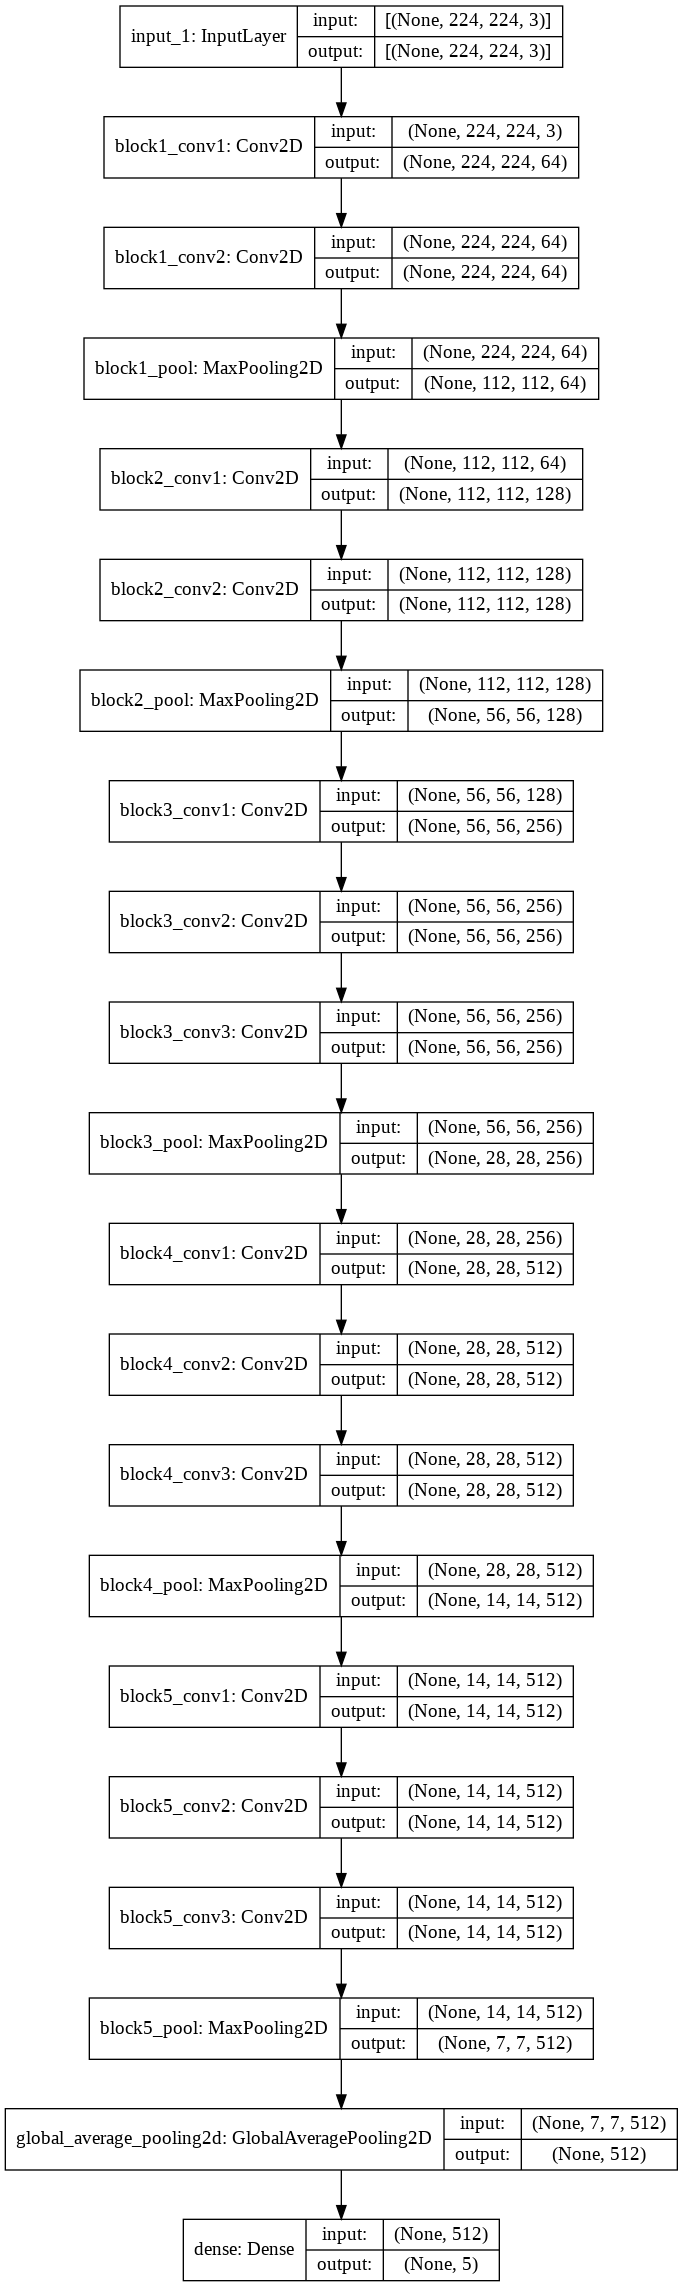

In [ ]:
# Instantiate the model without classification layer(s)
vgg_base = VGG16(weights='imagenet',
                 include_top=False, #no classification
                 input_shape=(224, 224, 3))

# 1st Transfer learning strategy: feature extraction
# Freeze the convolutional base
for layer in vgg_base.layers:
    layer.trainable = False

# Add classification head
# Grab the output
x = GlobalAveragePooling2D()(vgg_base.output)
# Add Dropout layer for regularization (reduce overfitting)
# x = Dropout(0.2)(x)
# Add Dense layer (5 classes, softmax activation)
outputs = Dense(n_classes, activation='softmax')(x)

# Define the new model
vggFE_full = Model(inputs=vgg_base.input,
                   outputs=outputs)

# Compile the model
vggFE_full.compile(loss='categorical_crossentropy',
                   optimizer=Adam(lr=base_learning_rate),
                   metrics=['accuracy'])

# Plot the model
plot_model(vggFE_full,
           model_folder/'vggFE_model_with_shape_info.png',
           show_shapes=True)

In [ ]:
# Display lenght of trainable variables
print(len(vggFE_full.trainable_variables))

# Display summary
vggFE_full.summary()

2
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### <font color=blue>P3.1.3 - Train the model</font>

In [ ]:
# Early Stopping / Checkpoint
mdlCheck = ModelCheckpoint(model_folder/'vggFE_ckpt.h5',
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True)

# Fit on training data
vggFE_history = vggFE_full.fit(vgg_train_ds,
                               epochs=n_epochs,
                               validation_data=vgg_valid_ds,
                               steps_per_epoch=train_size / batch_size,
                               validation_steps=valid_size / batch_size,
                               callbacks=[mdlCheck])

# Save the model: fully, weights only
vggFE_full.save(model_folder/'vggFE_model')

Epoch 1/10
500/500 [==============================] - 7055s 14s/step - loss: 0.8455 - accuracy: 0.6900 - val_loss: 0.4004 - val_accuracy: 0.8555
Epoch 2/10
500/500 [==============================] - 162s 324ms/step - loss: 0.3865 - accuracy: 0.8620 - val_loss: 0.3211 - val_accuracy: 0.8765
Epoch 3/10
500/500 [==============================] - 159s 319ms/step - loss: 0.3220 - accuracy: 0.8870 - val_loss: 0.2873 - val_accuracy: 0.9030
Epoch 4/10
500/500 [==============================] - 158s 317ms/step - loss: 0.2867 - accuracy: 0.9022 - val_loss: 0.2811 - val_accuracy: 0.9100
Epoch 5/10
500/500 [==============================] - 159s 317ms/step - loss: 0.2819 - accuracy: 0.9071 - val_loss: 0.2548 - val_accuracy: 0.9140
Epoch 6/10
500/500 [==============================] - 157s 313ms/step - loss: 0.2619 - accuracy: 0.9122 - val_loss: 0.2465 - val_accuracy: 0.9145
Epoch 7/10
500/500 [==============================] - 156s 312ms/step - loss: 0.2521 - accuracy: 0.9169 - val_loss: 0.2396 - 

### <font color=blue>P3.1.4 - Plot learning curves</font>

In [ ]:
# (Re)Load the model
vggFE_full = load_model(model_folder/'vggFE_model')

In [ ]:
# Function to plot learning curves
def std_learning_curves(history,
                        acc, val_acc,
                        loss, val_loss):
    
    plt.figure(figsize=(5,15))

    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')

    plt.show()

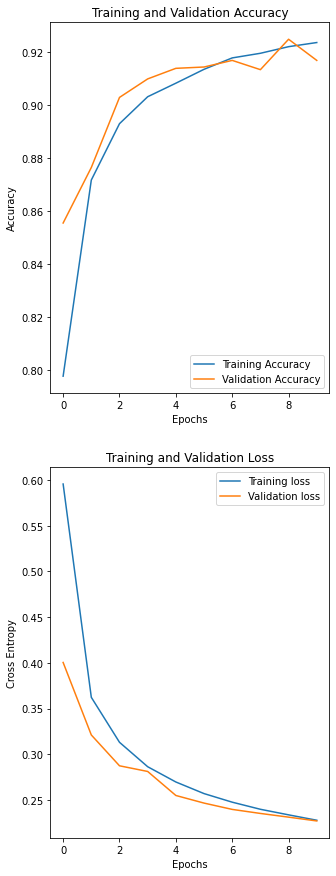

In [ ]:
# accuracy
vgg_acc = vggFE_history.history['accuracy']
vgg_val_acc = vggFE_history.history['val_accuracy']
# loss
vgg_loss = vggFE_history.history['loss']
vgg_val_loss = vggFE_history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(vggFE_history, 
                    vgg_acc, vgg_val_acc,
                    vgg_loss, vgg_val_loss)

### <font color=blue>P3.1.5 - Predict, evaluate, plot confusion matrix</font>

In [ ]:
# Generate generalization metrics
vggFE_score = vggFE_full.evaluate(vgg_test_ds)
vggFE_score

63/63 [==============================] - 771s 12s/step - loss: 0.2484 - accuracy: 0.9190


[0.24841399490833282, 0.9190000295639038]

In [ ]:
model_results = pd.DataFrame(vggFE_score,
                             columns=['vggFE'],
                             index=['loss', 'accuracy'])
model_results

,vggFE
loss,0.248414
accuracy,0.919000


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, list(classes.values()), rotation=45)
    plt.yticks(tick_marks, list(classes.values()))
    plt.title('Confusion matrix', fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.89      0.63      0.74       123
           1       0.95      0.98      0.97      1186
           2       0.85      0.94      0.89       538
           3       0.83      0.59      0.69        17
           4       0.90      0.61      0.73       136

    accuracy                           0.92      2000
   macro avg       0.89      0.75      0.80      2000
weighted avg       0.92      0.92      0.91      2000



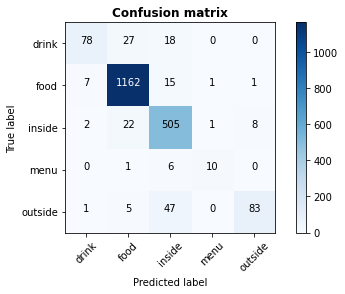

In [ ]:
# Predict
vggFE_preds = vggFE_full.predict(vgg_test_ds,
                                 batch_size=batch_size)
vggFE_y_pred=np.argmax(vggFE_preds,axis=1)

# Set labels
vggFE_labels = dict((v, k) for k, v in (vgg_test_ds.class_indices).items())

# Create confusion matrix
vggFE_cm = confusion_matrix(vgg_test_ds.classes, vggFE_y_pred)

# Call function to plot confusion matrix
plot_confusion_matrix(vggFE_cm, 
                      vggFE_labels,
                      cmap=plt.cm.Blues)

# Create and print classification report
print(classification_report(vgg_test_ds.classes, vggFE_y_pred))

## <font color=green>P3.2 - Fine-tuning with VGG-16</font>

### <font color=blue>P3.2.1 - Compose the model</font>

In [ ]:
# (Re)Load the model
vggFT_full = load_model(model_folder/'vggFE_model')

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vggFT_full.layers))

Number of layers in the base model:  21


In [ ]:
# Fine-tune from this layer onwards
vgg_fine_tune_at = 15

# 2nd Transfer learning strategy: partial fine-tuning
# Freeze all layers before the 'fine_tune_at' layer
# No training for 5 first layers (the low-level ones)
for layer in vggFT_full.layers[:vgg_fine_tune_at]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(vggFT_full.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d True
20 dense True


In [ ]:
# Compile the model
vggFT_full.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=base_learning_rate/10),
                    metrics=['accuracy'])

# Get summary
vggFT_full.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### <font color=blue>P3.2.2 - Continue training the model</font>

In [ ]:
# Fit on training data
vggFT_history = vggFT_full.fit(vgg_train_ds,
                               epochs=total_epochs,
                               validation_data=vgg_valid_ds,
                               steps_per_epoch=train_size / batch_size,
                               validation_steps=valid_size / batch_size)

# Save the model
vggFT_full.save(model_folder/'vggFT_model')

Epoch 1/20
500/500 [==============================] - 169s 336ms/step - loss: 0.3286 - accuracy: 0.8907 - val_loss: 0.1799 - val_accuracy: 0.9360
Epoch 2/20
500/500 [==============================] - 166s 332ms/step - loss: 0.1791 - accuracy: 0.9375 - val_loss: 0.1832 - val_accuracy: 0.9360
Epoch 3/20
500/500 [==============================] - 164s 328ms/step - loss: 0.0919 - accuracy: 0.9684 - val_loss: 0.1769 - val_accuracy: 0.9420
Epoch 4/20
500/500 [==============================] - 163s 326ms/step - loss: 0.0439 - accuracy: 0.9860 - val_loss: 0.2561 - val_accuracy: 0.9360
Epoch 5/20
500/500 [==============================] - 162s 325ms/step - loss: 0.0367 - accuracy: 0.9868 - val_loss: 0.2110 - val_accuracy: 0.9400
Epoch 6/20
500/500 [==============================] - 161s 322ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.2058 - val_accuracy: 0.9480
Epoch 7/20
500/500 [==============================] - 160s 320ms/step - loss: 0.0181 - accuracy: 0.9937 - val_loss: 0.2422 -

### <font color=blue>P3.2.3 - Plot learning curves</font>

In [ ]:
# (Re)Load the model
vggFT_full = load_model(model_folder/'vggFT_model')

In [ ]:
# Function to plot learning curves with fine-tuning
def finetuned_learning_curves(history,
                              acc, val_acc,
                              loss, val_loss):
    
    plt.figure(figsize=(6,15))

    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim(0.8, 1)
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')

    plt.show()

In [ ]:
# accuracy
vgg_acc += vggFT_history.history['accuracy']
vgg_val_acc += vggFT_history.history['val_accuracy']
# loss
vgg_loss += vggFT_history.history['loss']
vgg_val_loss += vggFT_history.history['val_loss']

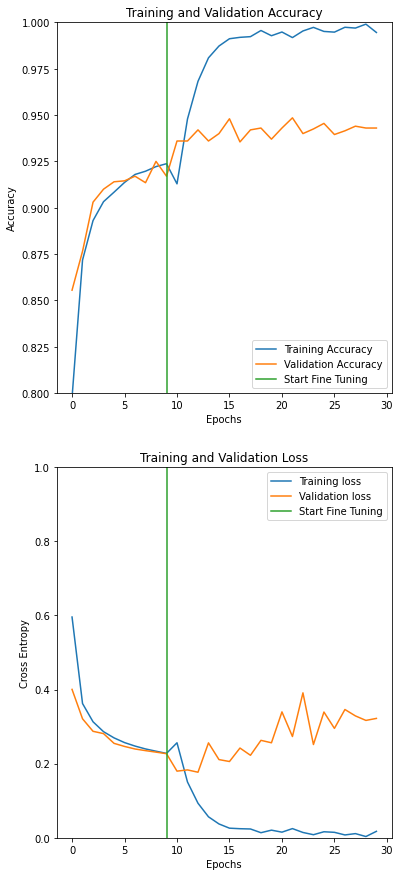

In [ ]:
# Call function to plot learning curves
finetuned_learning_curves(vggFT_history,
                          vgg_acc, vgg_val_acc,
                          vgg_loss, vgg_val_loss)

### <font color=blue>P3.2.4 - Predict, evaluate, plot confusion matrix</font>

In [ ]:
# Generate generalization metrics
vggFT_score = vggFT_full.evaluate(vgg_test_ds)
vggFT_score

63/63 [==============================] - 18s 275ms/step - loss: 0.3960 - accuracy: 0.9465


[0.39600008726119995, 0.9465000033378601]

In [ ]:
model_results = model_results.assign(vggFT = vggFT_score)
model_results

,vggFE,vggFT
loss,0.248414,0.3960
accuracy,0.919000,0.9465


In [ ]:
model_results.to_csv((model_folder / 'model_results.csv'), index=False)

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       123
           1       0.97      0.99      0.98      1186
           2       0.90      0.94      0.92       538
           3       0.90      0.53      0.67        17
           4       0.92      0.78      0.84       136

    accuracy                           0.95      2000
   macro avg       0.92      0.82      0.86      2000
weighted avg       0.95      0.95      0.95      2000



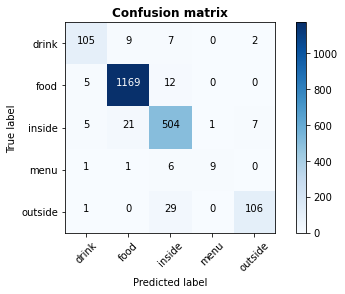

In [ ]:
# Predict
vggFT_preds = vggFT_full.predict(vgg_test_ds,
                                  batch_size=batch_size)
vggFT_y_pred=np.argmax(vggFT_preds,axis=1)

# Set labels
vggFT_labels = dict((v, k) for k, v in (vgg_test_ds.class_indices).items())

# Create confusion matrix
vggFT_cm = confusion_matrix(vgg_test_ds.classes, vggFT_y_pred)

# Call function to plot confusion matrix
plot_confusion_matrix(vggFT_cm, 
                      vggFT_labels,
                      cmap=plt.cm.Blues)

# Create and print classification report
print(classification_report(vgg_test_ds.classes, vggFT_y_pred))

Our fine-tuned VGG-16 model is obviously more accurate and performs better than the feature-extractor VGG-16 model.

### <font color=blue>P3.2.5 - Check performance</font>

Even if our fine-tuned model has performed better (**~95% accuracy, ~92% precision across all classes**), we would like to visualize **which images were wrongly classified**.

In [ ]:
# Get the list of test file names
vgg_fnames = vgg_test_ds.filenames

# Get the list of true labels
vgg_ground_truth = vgg_test_ds.classes

# Get the dictionary of classes
vgg_label2index = vgg_test_ds.class_indices

# Get the list of classes
vgg_idx2label = list(vgg_label2index.keys())
print('The list of labels: ', vgg_idx2label)

The list of labels:  ['drink', 'food', 'inside', 'menu', 'outside']


Below we get the number of incorrect predictions.

In [ ]:
# Create an array of incorrect predictions
errors = np.where(vggFT_y_pred != vgg_ground_truth)[0]
print('Number of errors = {} / {}'.format(len(errors), test_size))

Number of errors = 107 / 2000


In [ ]:
errors

array([  24,   31,   35,   37,   41,   45,   49,   59,   60,   61,   63,
         68,   80,   92,   99,  105,  107,  122,  277,  306,  310,  346,
        464,  508,  545,  623,  711,  713,  771,  890,  965, 1077, 1217,
       1279, 1300, 1311, 1314, 1318, 1328, 1332, 1355, 1366, 1390, 1446,
       1455, 1462, 1525, 1554, 1560, 1564, 1574, 1577, 1583, 1596, 1601,
       1681, 1685, 1690, 1703, 1712, 1725, 1747, 1749, 1753, 1769, 1778,
       1792, 1797, 1839, 1849, 1850, 1851, 1853, 1854, 1858, 1861, 1863,
       1865, 1870, 1879, 1881, 1883, 1884, 1886, 1893, 1896, 1899, 1903,
       1912, 1914, 1915, 1925, 1926, 1934, 1940, 1947, 1958, 1963, 1965,
       1970, 1972, 1978, 1983, 1985, 1988, 1989, 1992])

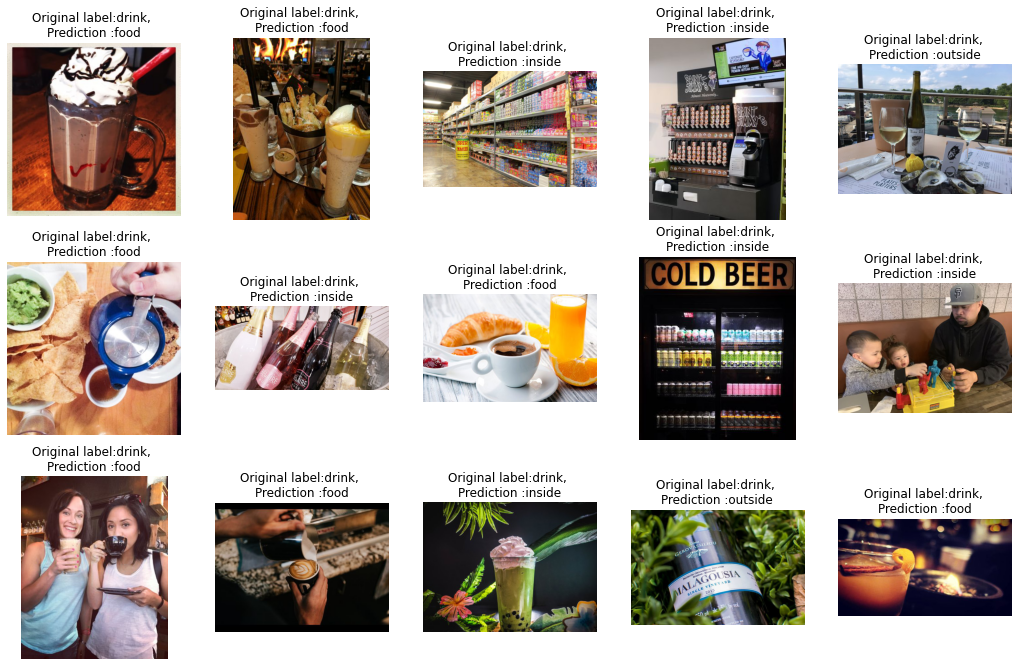

In [ ]:
# https://learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/
# https://datauab.github.io/catsvsdogs/
# Check errors
fig = plt.figure(figsize=(18,15))
for i in range(15):
    pred_class = np.argmax(vggFT_preds[errors[i]])
    pred_label = vgg_idx2label[pred_class]
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_title('Original label:{}, \nPrediction :{}'.format(
        vgg_fnames[errors[i]].split('/')[0],
        pred_label))
    
    original = tf.keras.preprocessing.image.load_img('{}/{}'.format(test_folder,
                                                                    vgg_fnames[errors[i]]))
    
    plt.subplots_adjust(top=0.7)
    plt.axis('off')
    plt.imshow(original)
plt.show()

# <font color=salmon>CONCLUSION</font>

Our opinion for this part of our job is that we have a good precision in image classification with **Transfer Learning on fine-tuning scheme**.

However, it could be an idea to check the initial label before modelisation: 
- some labels are incorrects;
- some pictures could lead to misinterpretation, even for an human being because of multi-labelling choice.